# Additional Preprocessing

## Import and setup

first import the pkl dataset and convert to pandas dataframe

In [1]:
import pandas as pd
df = pd.read_pickle('all-shots.pkl') 
df = df.to_pandas(use_pyarrow_extension_array=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4231262 entries, 0 to 4231261
Data columns (total 26 columns):
 #   Column          Dtype                
---  ------          -----                
 0   SEASON_1        int64[pyarrow]       
 1   SEASON_2        large_string[pyarrow]
 2   TEAM_ID         int64[pyarrow]       
 3   TEAM_NAME       large_string[pyarrow]
 4   PLAYER_ID       int64[pyarrow]       
 5   PLAYER_NAME     large_string[pyarrow]
 6   POSITION_GROUP  large_string[pyarrow]
 7   POSITION        large_string[pyarrow]
 8   GAME_DATE       large_string[pyarrow]
 9   GAME_ID         int64[pyarrow]       
 10  HOME_TEAM       large_string[pyarrow]
 11  AWAY_TEAM       large_string[pyarrow]
 12  EVENT_TYPE      large_string[pyarrow]
 13  SHOT_MADE       bool[pyarrow]        
 14  ACTION_TYPE     large_string[pyarrow]
 15  SHOT_TYPE       large_string[pyarrow]
 16  BASIC_ZONE      large_string[pyarrow]
 17  ZONE_NAME       large_string[pyarrow]
 18  ZONE_ABB        large_

## Aggregating Win Rates

Going to aggregate by season by team

In [2]:
def calc_points(row):
    if not row['SHOT_MADE']:
        return 0
    else:
        if row['SHOT_TYPE'] == '3PT Field Goal':
            return 3
        else:
            return 2
        # perhaps use elif for returning 2 and else to Raise some error

df['points'] = df.apply(calc_points, axis=1)

for each season - each game  there are two teams each with summed score

In [3]:
df_game_team = (
    df
    .groupby(['SEASON_1','GAME_ID', 'TEAM_NAME'], as_index=False)
    .agg(team_points=('points', 'sum'))
)
df_game_team.head()

,SEASON_1,GAME_ID,TEAM_NAME,team_points
0,2004,20300001,Miami Heat,60
1,2004,20300001,Philadelphia 76ers,73
2,2004,20300002,Phoenix Suns,65
3,2004,20300002,San Antonio Spurs,63
4,2004,20300003,Dallas Mavericks,71


identify the winner for each 

In [4]:
df_game_team['max_points_in_game'] = (
    df_game_team
    .groupby('GAME_ID')['team_points']
    .transform('max')
)

df_game_team['won_game'] = (df_game_team['team_points'] == df_game_team['max_points_in_game']).astype(int)
df_game_team.head()

,SEASON_1,GAME_ID,TEAM_NAME,team_points,max_points_in_game,won_game
0,2004,20300001,Miami Heat,60,73,0
1,2004,20300001,Philadelphia 76ers,73,73,1
2,2004,20300002,Phoenix Suns,65,65,1
3,2004,20300002,San Antonio Spurs,63,65,0
4,2004,20300003,Dallas Mavericks,71,97,0


aggregate to team level win rates for each season

In [5]:
df_win_rate = (
    df_game_team
    .groupby(['SEASON_1','TEAM_NAME'], as_index=False)
    .agg(
        total_games=('GAME_ID', 'nunique'), #or .count()
        total_wins=('won_game', 'sum')
    )
)
df_win_rate['win_rate'] = df_win_rate['total_wins']/df_win_rate['total_games']
df_win_rate.head()

,SEASON_1,TEAM_NAME,total_games,total_wins,win_rate
0,2004,Atlanta Hawks,82,35,0.426829
1,2004,Boston Celtics,82,34,0.414634
2,2004,Chicago Bulls,82,33,0.402439
3,2004,Cleveland Cavaliers,82,33,0.402439
4,2004,Dallas Mavericks,82,54,0.658537


this time around you should have more than 30 datapoints 

In [6]:
df_win_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype                
---  ------       --------------  -----                
 0   SEASON_1     629 non-null    int64[pyarrow]       
 1   TEAM_NAME    629 non-null    large_string[pyarrow]
 2   total_games  629 non-null    int64                
 3   total_wins   629 non-null    int64                
 4   win_rate     629 non-null    float64              
dtypes: float64(1), int64(2), int64[pyarrow](1), large_string[pyarrow](1)
memory usage: 34.6 KB


## Aggregating 3pt Attempt Rates

going to aggregate by season by team

In [8]:
df_attempt = (
    df
    .groupby(['SEASON_1','TEAM_NAME'])
    .agg(
        total_attempts=('SHOT_TYPE', 'size'),
        three_pt_attempts=('SHOT_TYPE', lambda x: (x=='3PT Field Goal').sum())
    )
    .reset_index()
)

df_attempt['three_pt_attempts'] = (df_attempt['three_pt_attempts']).astype(int)

# creating three pt attempt rate column
df_attempt['three_pt_attempt_rate'] = df_attempt['three_pt_attempts']/df_attempt['total_attempts']

df_attempt.head()

,SEASON_1,TEAM_NAME,total_attempts,three_pt_attempts,three_pt_attempt_rate
0,2004,Atlanta Hawks,6529,1249,0.1913
1,2004,Boston Celtics,6415,1599,0.24926
2,2004,Chicago Bulls,6753,1256,0.185991
3,2004,Cleveland Cavaliers,6753,786,0.116393
4,2004,Dallas Mavericks,7230,1456,0.201383


In [10]:
df_attempt.head()

,SEASON_1,TEAM_NAME,total_attempts,three_pt_attempts,three_pt_attempt_rate
0,2004,Atlanta Hawks,6529,1249,0.1913
1,2004,Boston Celtics,6415,1599,0.24926
2,2004,Chicago Bulls,6753,1256,0.185991
3,2004,Cleveland Cavaliers,6753,786,0.116393
4,2004,Dallas Mavericks,7230,1456,0.201383


## Merging Aggregations

make sure the win rates and attempt dataframes have the same number of instances

In [14]:
assert df_attempt.shape[0] == df_win_rate.shape[0]

merge on season_1, team_name columns. keeping relevant columns for hypothesis testing

In [18]:
df_merged = df_attempt.merge(df_win_rate, on=['SEASON_1', 'TEAM_NAME'], how='inner')
df_merged = df_merged[['SEASON_1', 'TEAM_NAME', 'three_pt_attempt_rate', 'win_rate']]
print(df_merged.info())
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype                
---  ------                 --------------  -----                
 0   SEASON_1               629 non-null    int64[pyarrow]       
 1   TEAM_NAME              629 non-null    large_string[pyarrow]
 2   three_pt_attempt_rate  629 non-null    double[pyarrow]      
 3   win_rate               629 non-null    float64              
dtypes: double[pyarrow](1), float64(1), int64[pyarrow](1), large_string[pyarrow](1)
memory usage: 29.8 KB
None


,SEASON_1,TEAM_NAME,three_pt_attempt_rate,win_rate
0,2004,Atlanta Hawks,0.1913,0.426829
1,2004,Boston Celtics,0.24926,0.414634
2,2004,Chicago Bulls,0.185991,0.402439
3,2004,Cleveland Cavaliers,0.116393,0.402439
4,2004,Dallas Mavericks,0.201383,0.658537


merge looks good with no null entries

In [19]:
three_pt_attempt_rate = df_merged['three_pt_attempt_rate']
win_rate = df_merged['win_rate']

# Normality Testing

In [25]:
# for visuals
import statsmodels.api as sm
from matplotlib import pyplot as plt


# for normality tests
from scipy.stats import anderson, shapiro, kstest, normaltest


alpha = 0.05

## Basic Histograms

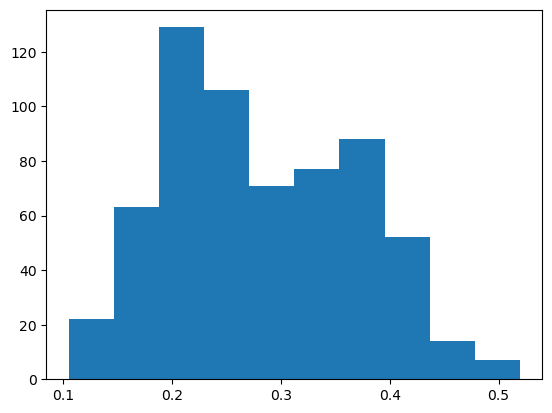

In [23]:
plt.hist(three_pt_attempt_rate)
plt.show()

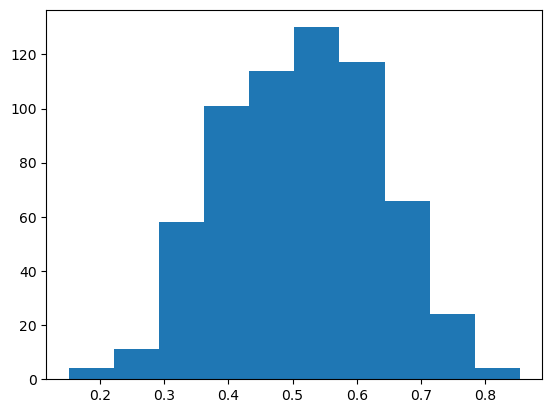

In [24]:
plt.hist(win_rate)
plt.show()

## QQ Plot for three_pt_attempt_rate

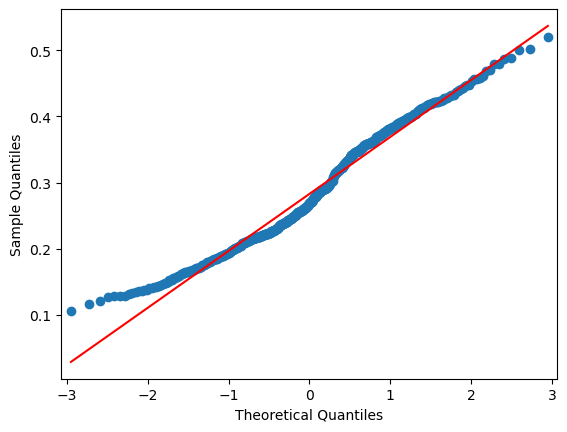

In [21]:
sm.qqplot(
    data=three_pt_attempt_rate,
    line='s'
)
plt.show()

## QQ Plot for win_rate

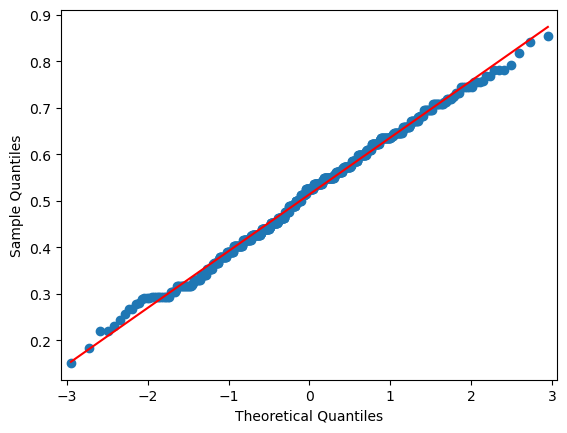

In [22]:
sm.qqplot(
    data=win_rate,
    line='s'
)
plt.show()

## Shapiro-Wilk Test

H0: the sample follows normal distribution


H1: the sample does not follow normal distribution.

In [28]:
# Testing three_pt_attempt_rate
stat, p = shapiro(three_pt_attempt_rate)
print(f'statistic: {stat}\np-value: {p}\n')
'sample follows normal distribution (Fail to reject H0)' if p > alpha else 'sample does not follow normal distribution (Reject H0)'

statistic: 0.9721470659033769
p-value: 1.4518866472576583e-09



'sample does not follow normal distribution (Reject H0)'

In [29]:
# Testing win_rate
stat, p = shapiro(win_rate)
print(f'statistic: {stat}\np-value: {p}\n')
'sample follows normal distribution (Fail to reject H0)' if p > alpha else 'sample does not follow normal distribution (Reject H0)'

statistic: 0.9945683670112669
p-value: 0.02457922165138332



'sample does not follow normal distribution (Reject H0)'

## DAgostino's K^2 Test

H0: the sample follows normal distribution


H1: the sample does not follow normal distribution.

In [30]:
# Testing three_pt_attempt_rate
stat, p = normaltest(three_pt_attempt_rate)
print(f'statistic: {stat}\np-value: {p}\n')
'sample follows normal distribution (Fail to reject H0)' if p > alpha else 'sample does not follow normal distribution (Reject H0)'

statistic: 64.55732383216143
p-value: 9.58418629039721e-15



'sample does not follow normal distribution (Reject H0)'

In [31]:
# Testing win_rate
stat, p = normaltest(win_rate)
print(f'statistic: {stat}\np-value: {p}\n')
'sample follows normal distribution (Fail to reject H0)' if p > alpha else 'sample does not follow normal distribution (Reject H0)'

statistic: 7.624196297793584
p-value: 0.022101757496390696



'sample does not follow normal distribution (Reject H0)'

## Anderson-Darling Test

H0: the sample follows normal distribution


H1: the sample does not follow normal distribution.

In [36]:
ad_3pt = anderson(three_pt_attempt_rate, 'norm')

for i in range(len(ad_3pt.critical_values)):
    sl, cv = ad_3pt.significance_level[i], ad_3pt.critical_values[i]
    result = f'sample follows normal distribution (Fail to reject H0) at sig level {sl}' if ad_3pt.statistic < ad_3pt.critical_values[i] else f'sample does not follow normal distribution (Reject H0) at sig level {sl}'
    print(result)

sample does not follow normal distribution (Reject H0) at sig level 15.0
sample does not follow normal distribution (Reject H0) at sig level 10.0
sample does not follow normal distribution (Reject H0) at sig level 5.0
sample does not follow normal distribution (Reject H0) at sig level 2.5
sample does not follow normal distribution (Reject H0) at sig level 1.0


In [37]:
# Testing win_rate
ad_wr = anderson(win_rate, 'norm')

for i in range(len(ad_wr.critical_values)):
    sl, cv = ad_wr.significance_level[i], ad_wr.critical_values[i]
    result = f'sample follows normal distribution (Fail to reject H0) at sig level {sl}' if ad_wr.statistic < ad_wr.critical_values[i] else f'sample does not follow normal distribution (Reject H0) at sig level {sl}'
    print(result)

sample does not follow normal distribution (Reject H0) at sig level 15.0
sample does not follow normal distribution (Reject H0) at sig level 10.0
sample does not follow normal distribution (Reject H0) at sig level 5.0
sample does not follow normal distribution (Reject H0) at sig level 2.5
sample does not follow normal distribution (Reject H0) at sig level 1.0


## Conclusion: ...

# Nonparametric Correlation Testing

In [38]:
from scipy.stats import spearmanr, kendalltau

## Spearman's Rank Correlation

H0: two samples are independent


H1: two samples are not independent

In [41]:
corr, p = spearmanr(three_pt_attempt_rate, win_rate)
print(f"Spearman's rank correlation: {corr:.3f}, p-value={p:.3g}")
'indepent samples (Fail to reject H0)' if p > alpha else 'dependent samples (Reject H0)'

Spearman's rank correlation: 0.137, p-value=0.000554


'dependent samples (Reject H0)'

## Kendall's Rank Correlation

H0: two samples are independent


H1: two samples are not independent

In [42]:
corr, p = kendalltau(three_pt_attempt_rate, win_rate)
print(f"Kendall's tau: {corr:.3f}, p-value={p:.3g}")
'indepent samples (Fail to reject H0)' if p > alpha else 'dependent samples (Reject H0)'

Kendall's tau: 0.094, p-value=0.000465


'dependent samples (Reject H0)'